<a href="https://colab.research.google.com/github/ElFosco/NLP_assignments/blob/carlo/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

**Due to**: 23/12/2021 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Fact checking, Neural Languange Inference (**NLI**)

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## 2.1 Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

```
{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}
```

---

**Not Verifiable**

```
{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}
```

---

## 2.2 Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [ ]:
import os, shutil  # file management
import sys  # system
import pandas as pd  # dataframe management
import numpy as np  # data manipulation
from tqdm import tqdm  # useful during debugging (progress bars)
from typing import List, Callable, Dict  # typing
import re  # regex
import urllib.request  # download files
import zipfile  # unzip files
import gensim  # embeddings
import gensim.downloader as gloader  # embeddings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # one-hot encoding
from matplotlib import pyplot as plt  # Plots
import nltk
from nltk.corpus import stopwords  # Remove stopwords
from nltk.stem import SnowballStemmer  # Stemming
from nltk.stem import WordNetLemmatizer

# Models
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Bidirectional, Dense, SimpleRNN,GlobalAveragePooling1D,Flatten, Concatenate, Add, Average, Dot
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras import Input, Model

# F1
from sklearn.metrics import f1_score, accuracy_score, classification_report
from functools import partial

# Grid search
from sklearn.model_selection import GridSearchCV
import copy

#split
from sklearn.model_selection import train_test_split

In [ ]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

In [ ]:
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

STEMMER = SnowballStemmer("english")

nltk.download('wordnet') 
LEMMATIZER = WordNetLemmatizer()


def clean_text(text):

  #delete multiple quotes
  delete_multiple_quotes = "''|``|\.\."
  ris = re.sub(delete_multiple_quotes, '', text)

  #get only the sentence, delete the number before it and the keywords after it
  start_symbol = "^[0-9]*\\t"
  end_symbol = "( )?[\.|\?|\!|\,]( )?(\\t.*)?$"
  ris = re.sub(start_symbol, '', ris)
  ris = re.sub(end_symbol, '', ris)

  #convert the brackets into token, done for the claim string
  ris = re.sub("\(", " -LRB- ",ris)
  ris = re.sub("\)", " -RRB- ",ris)

  #check if numbers are present between tokens LSB and RSB, if it's not the case delete the content
  delete_content_lsb = "-LRB-(.[^0-9]*)-RRB-"
  ris = re.sub(delete_content_lsb, '', ris)

  #check if numbers are present in brackets, if it's not the case delete the content
  delete_content_brackets = "-LSB-(.[^0-9]*)-RSB-"
  ris = re.sub(delete_content_brackets, '', ris)

  #delete brackets token
  delete_brackets = "-LRB-|-RRB-|-RSB-|-LSB-"
  ris = re.sub(delete_brackets, ' ', ris)

  #deal with the &
  ris = re.sub("\&", ' and ', ris)

  #deal with the *
  ris = re.sub("star * reach", 'star*reach', ris)

  #remove tokens that we are not interested in
  remove_tokens = "[\-\"?!#`\$]"  # |[\.] " # added $ and \. handled alone`
  ris = re.sub(remove_tokens, ' ', ris)

  #delete additional spaces and last space
  #remove_spaces = "[ ]+"
  #remove_last_spaces= " $"
  #ris = re.sub(remove_spaces, ' ', ris)
  #ris = re.sub(remove_last_spaces, '', ris)

  #ris = ' '.join([x for x in ris.split() if x and x not in STOPWORDS])
  ris.strip()

  ris = " ".join([LEMMATIZER.lemmatize(word) for word in ris.split()])

  #handle ' (?)

  return ris.lower()

id=1294
df = pd.read_csv('dataset/test_pairs.csv')
df = df.drop(['Unnamed: 0'],axis=1)
print(df.iloc[id]['Evidence'])
df['Evidence'] = df.apply(lambda row : clean_text(row['Evidence']), axis = 1)
df['Claim'] = df.apply(lambda row : clean_text(row['Claim']), axis = 1)
print(df.iloc[id]['Evidence'])
print(df.iloc[id]['Claim'])

In [ ]:
X = df.drop(['Label','ID'],axis=1)
y = df['Label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, random_state=42)

In [35]:
X = df.drop(['Label','ID'],axis=1)
y = df['Label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

# 1 supports

# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build `(claim, evidence)` pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

[**Note**]: The dataset requires some text cleaning as you may have noticed!


# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## 4.1 Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## 5.1 Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its asssociated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: `[batch_size, max_tokens]`
*    Evidence: `[batch_size, max_tokens]`

Moreover, after the embedding layer, we'll have:

*    Claim: `[batch_size, max_tokens, embedding_dim]`
*    Evidence: `[batch_size, max_tokens, embedding_dim]`

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: `[batch_size, dim]`

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

1.   Encode token sequences via a RNN and take the last state as the sentence embedding.

2.  Encode token sequences via a RNN and average all the output states.

3.  Encode token sequences via a simple MLP layer. In particular, if your input is a `[batch_size, max_tokens, embedding_dim]` tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a `[batch_size, embedding_dim]` 2D matrix. Alternatively, you can reshape the 3D input tensor from `[batch_size, max_tokens, embedding_dim]` to `[batch_size, max_tokens * embedding_dim]` and then apply the MLP layer.

4.   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

## Create GloVe embeddings (keep attention to the size, maybe we have to change it)

In [ ]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [ ]:
def check_OOV_terms(embedding_vocabulary: List[str],
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_vocabulary: pre-trained word embedding model vocab (list)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


def update_embedding_matrix(embedding_model: np.ndarray, 
                            embedding_dimension: int,
                            word_to_idx: Dict[str, int],
                            vocab_size: int,
                            oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained emdedding matrix

    :param embedding_model: pre-trained embedding matrix
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[idx]
        except (TypeError, IndexError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


## Tokenizer

In [ ]:
class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None,
                 embedding_model_type=None, tokenizer_args=None, embedding_model=None):
        if build_embedding_matrix:
            assert embedding_model_type is not None
            assert embedding_dimension is not None and type(embedding_dimension) == int

        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model_type = embedding_model_type
        self.embedding_model = embedding_model
        self.embedding_matrix = None
        self.vocab = None

        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)

        self.tokenizer_args = tokenizer_args

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')

        self.vocab = self.tokenizer.word_index

        if self.build_embedding_matrix:
            if self.embedding_model is None:
              print('Loading embedding model! It may take a while...')
              self.embedding_model = load_embedding_model(model_type=self.embedding_model_type, 
                                                          embedding_dimension=self.embedding_dimension)
            
            print('Checking OOV terms in train...')
            self.oov_terms_train = check_OOV_terms(embedding_vocabulary=set(self.embedding_model.vocab.keys()),
                                             word_listing=list(self.vocab.keys()))
            
            print("Total OOV terms: {0} ({1:.2f}%)".format(len(self.oov_terms_train), 100*float(len(self.oov_terms_train)) / len(self.vocab)))

            print('Building the embedding matrix for train...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.vocab,
                                                           vocab_size=len(self.vocab)+1,          
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms_train)
            print('Done for train!')

    def update_vocab(self, data, **kwargs):
      self.tokenizer.fit_on_texts(data)
      if self.build_embedding_matrix:
        old_vocab = self.vocab
        self.vocab = self.tokenizer.word_index
        print('Checking OOV terms...')
        self.oov_terms = check_OOV_terms(embedding_vocabulary=set(old_vocab.keys()), 
                                         word_listing=list(self.vocab.keys()))
        
        print("Total OOV terms: {0} ({1:.2f}%)".format(len(self.oov_terms), 100*float(len(self.oov_terms)) / len(self.vocab)))

        print('Building the embedding matrix...')
        self.embedding_matrix = update_embedding_matrix(embedding_model=self.embedding_matrix,
                                                       word_to_idx=self.vocab,
                                                       vocab_size=len(self.vocab)+1,          
                                                       embedding_dimension=self.embedding_dimension,
                                                       oov_terms=self.oov_terms)

    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_model_type': self.embedding_model_type,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.vocab) + 1,
        }

    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)

### Downloading embeddings

In [ ]:
embedding_dimension = 50
embedding_model = load_embedding_model(model_type="glove", 
                                       embedding_dimension=embedding_dimension)

### Creating tokenizer

In [ ]:
tokenizer_args = {
    'oov_token': "OOV_TOKEN",  # The vocabulary id for unknown terms during text conversion
    'lower' : True,  # default
    'filters' : '' 
}

tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           build_embedding_matrix=True,
                           embedding_dimension=embedding_dimension,
                           embedding_model_type="glove", 
                           embedding_model=embedding_model)
tokenizer.build_vocab(X_train["Evidence"])
tokenizer.update_vocab(X_train["Claim"])

tokenizer_info = tokenizer.get_info()

print('Tokenizer info: ', tokenizer_info)

### Updating tokenizer with validation and test

In [ ]:
tokenizer.update_vocab(X_val["Claim"])
tokenizer.update_vocab(X_test["Claim"])
tokenizer.update_vocab(X_val["Evidence"])
tokenizer.update_vocab(X_test["Evidence"])

In [ ]:
a = list(tokenizer.vocab.keys())
a.sort()
print(a)

### Padding for x and computation of max sequence length

In [ ]:
def convert_text(df, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """


    text_ids_claim = tokenizer.convert_tokens_to_ids(df['Claim'])
    text_ids_evidence = tokenizer.convert_tokens_to_ids(df['Evidence'])

    # Padding
    if is_training:
        max_seq_length_claim = int(np.quantile([len(seq) for seq in text_ids_claim], 0.99))
        max_seq_length_evidence = int(np.quantile([len(seq) for seq in text_ids_evidence], 0.99))

        if max_seq_length_claim > max_seq_length_evidence:
            max_seq_length = max_seq_length_claim
        else:
          max_seq_length = max_seq_length_evidence

    else:
        assert max_seq_length is not None

    claims = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids_claim]
    claims = np.array([seq[:max_seq_length] for seq in claims])
    
    evidences = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids_evidence]
    evidences = np.array([seq[:max_seq_length] for seq in evidences])

    return max_seq_length, np.array([claims, evidences])
        

max_seq_length, x_train = convert_text(X_train, tokenizer, True)
print("Max token sequence: {}".format(max_seq_length))
print('X train shape: ', x_train.shape)

_, x_val = convert_text(X_val, tokenizer, False, max_seq_length)
print('X val shape: ', x_val.shape)

_, x_test = convert_text(X_test, tokenizer, False, max_seq_length)
print('X test shape: ', x_test.shape)

## Sentence embedding

---



In [ ]:
embedding_vector_length = embedding_dimension

In [ ]:
def firstModel(embedding_vector_length,dim, start_lr=0.001):

  input = Input(shape=(max_seq_length))
  x = Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                      input_length=max_seq_length, 
                      trainable=True, 
                      mask_zero=True)(input)
  last_state = SimpleRNN(dim,return_state=True)(x)   #can we add a Bidirectional layer??
  
  RNN = Model(input, last_state, name="firstModel")
  return RNN

In [ ]:
def secondModel(embedding_vector_length,dim, start_lr=0.001):
  
  input = Input(shape=(max_seq_length))
  x = Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                      input_length=max_seq_length, 
                      trainable=False, 
                      mask_zero=True)(input)
  states = SimpleRNN(dim,return_sequences=True)(x)   #can we add a Bidirectional layer??
  output = GlobalAveragePooling1D()(states)
  RNN = Model(input, output, name="secondModel")
  
  
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      start_lr,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
  
  optim = Adam(learning_rate=lr_schedule)

  RNN.compile(loss='categorical_crossentropy', optimizer=optim, 
                  metrics=['accuracy']) #to check
  return RNN

In [ ]:
def thirdModel(embedding_vector_length, dim, start_lr=0.001):
  
  MLP = Sequential()
  MLP.add(Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                      input_length=max_seq_length, 
                      trainable=False, 
                      mask_zero=True))
  MLP.add(Flatten())
  MLP.add(Dense(350, input_shape=(embedding_vector_length*max_seq_length,), activation='relu'))
  MLP.add(Dense(50, activation='relu'))
  MLP.add(Dense(dim, activation='sigmoid'))
  
  
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      start_lr,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
  
  optim = Adam(learning_rate=lr_schedule)

  MLP.compile(loss='categorical_crossentropy', optimizer=optim, 
                  metrics=['accuracy']) #to check

  return MLP

In [ ]:
def fourthModel(embedding_vector_length, start_lr=0.001):
  
  EMB = Sequential()
  EMB.add(Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                      input_length=max_seq_length, 
                      trainable=False, 
                      mask_zero=True))  # do not train embeddings, but we can do it
  EMB.add(GlobalAveragePooling1D())
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      start_lr,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
  
  optim = Adam(learning_rate=lr_schedule)

  EMB.compile(loss='categorical_crossentropy', optimizer=optim, 
                  metrics=['accuracy']) #to check
  return EMB

## Create GloVe embeddings (keep attention to the size, maybe we have to change it)

In [9]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [10]:
def check_OOV_terms(embedding_vocabulary: List[str],
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_vocabulary: pre-trained word embedding model vocab (list)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [11]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


def update_embedding_matrix(embedding_model: np.ndarray, 
                            embedding_dimension: int,
                            word_to_idx: Dict[str, int],
                            vocab_size: int,
                            oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained emdedding matrix

    :param embedding_model: pre-trained embedding matrix
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[idx]
        except (TypeError, IndexError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


### Model definition

In [ ]:
from keras.layers import concatenate, add, average, dot
def Classifier(embed_model, model_type, type_merge, cosine_similarity):
  input_c = Input(shape=(max_seq_length))
  input_e = Input(shape=(max_seq_length))
  embedding_c = embed_model(input_c)
  embedding_e = embed_model(input_e)

  if model_type == "firstModel":
    embedding_c = embedding_c[1]
    embedding_e = embedding_e[1]

  if type_merge == "concat":
      class_input = concatenate([embedding_c, embedding_e])
  elif type_merge == "sum":
      class_input = add([embedding_c, embedding_e])
  elif type_merge == "mean":
      class_input = average([embedding_c, embedding_e])

  if cosine_similarity:
      cos_sim = dot([embedding_c, embedding_e], axes=1, normalize=True)
      class_input = concatenate([class_input, cos_sim])

  x = Dense(32, activation="relu")(class_input)
  output = Dense(1, activation="sigmoid")(x)

  return Model([input_c, input_e], output, name="Classifier")

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      0.0001,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
optim = Adam(learning_rate=lr_schedule)
embed_model = firstModel(embedding_vector_length, 64)
base_model = Classifier(embed_model, "firstModel", "mean", cosine_similarity=True)
base_model.compile(loss='binary_crossentropy', optimizer=optim, 
                   metrics=['accuracy'])
history = base_model.fit(x=[x_train[0], x_train[1]], y=y_train, 
                         validation_data=([x_val[0], x_val[1]], y_val), 
                         epochs=60, batch_size=1024)

In [ ]:
predictions = base_model.predict([x_train[0], x_train[1]])
print(classification_report(y_train, np.round(predictions)))

In [ ]:
predictions = base_model.predict([x_val[0], x_val[1]])
print(classification_report(y_val, np.round(predictions)))

In [ ]:
class Classifier(tf.keras.Model):
  def __init__(self, embedding_vector_length, dim, type_embed, type_merge, 
               cosine_similarity=False, embed_trainable=True, start_lr=0.001, **kwargs):
    super(Classifier, self).__init__(**kwargs)

    self.type_embed = type_embed
    self.cosine_similarity = cosine_similarity

    self.embedding_1 = Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                        input_length=max_seq_length, 
                        trainable=embed_trainable, 
                        mask_zero=True)
    if type_embed == "firstModel":
      self.embedding_2 = SimpleRNN(dim,return_state=True)
    elif type_embed == "secondModel":
      self.embedding_2 = SimpleRNN(dim,return_sequences=True)
      self.embedding_3 = GlobalAveragePooling1D()
    elif type_embed == "thirdModel":
      self.embedding_2 = Flatten()
      self.embedding_3 = Dense(350, input_shape=(embedding_vector_length*max_seq_length,), activation='relu')
      self.embedding_4 = Dense(50, activation='relu')
      self.embedding_5 = Dense(dim, activation='sigmoid')
    elif type_embed == "fourthModel":
      self.embedding_2 = GlobalAveragePooling1D()

    if type_merge == "concat":
      self.merge = Concatenate()
    elif type_merge == "sum":
      self.merge = Add()
    elif type_merge == "mean":
      self.merge = Average()

    self.concatenate = Concatenate()

    self.cosine_similarity = Dot(axes=1, normalize=True)

    self.dense_1 = Dense(16, activation="relu")
    self.activation = Dense(1, activation="sigmoid")

  def call(self, input):
    claim = input[0]
    evidence = input[1]
    c_embed = self.embedding_1(claim)
    e_embed = self.embedding_1(evidence)

    c_embed = self.embedding_2(c_embed)
    e_embed = self.embedding_2(e_embed)

    if self.type_embed == "thirdModel":
      c_embed = self.embedding_3(c_embed)
      e_embed = self.embedding_3(e_embed)
      c_embed = self.embedding_4(c_embed)
      e_embed = self.embedding_4(e_embed)
      c_embed = self.embedding_5(c_embed)
      e_embed = self.embedding_5(e_embed)
    elif self.type_embed == "secondModel":
      c_embed = self.embedding_3(c_embed)
      e_embed = self.embedding_3(e_embed)

    if self.type_embed == "firstModel":
      c_embed = c_embed[1]
      e_embed = e_embed[1]

    class_input = self.merge([c_embed, e_embed])

    if self.cosine_similarity:
      cos_sim = self.cosine_similarity([c_embed, e_embed])
      class_input = self.concatenate([class_input, cos_sim])

    x = self.dense_1(class_input)
    return self.activation(x)

### Train

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      0.001,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
optim = Adam(learning_rate=lr_schedule)
base_model = Classifier(embedding_vector_length, 32, "firstModel", "mean", 
                        embed_trainable=True, cosine_similarity=True)
base_model.compile(loss='binary_crossentropy', optimizer=optim, 
                   metrics=['accuracy'])
history = base_model.fit(x=[x_train[0], x_train[1]], y=y_train, 
                         validation_data=([x_val[0], x_val[1]], y_val), 
                         epochs=100, batch_size=128)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
base_model.evaluate([x_test[0], x_test[1]], y_test)

## Tokenizer

In [12]:
# Glove -> 50, 100, 200, 300

class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None,
                 embedding_model_type=None, tokenizer_args=None, embedding_model=None):
        if build_embedding_matrix:
            assert embedding_model_type is not None
            assert embedding_dimension is not None and type(embedding_dimension) == int

        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model_type = embedding_model_type
        self.embedding_model = embedding_model
        self.embedding_matrix = None
        self.vocab = None

        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)

        self.tokenizer_args = tokenizer_args

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')

        self.vocab = self.tokenizer.word_index

        if self.build_embedding_matrix:
            if self.embedding_model is None:
              print('Loading embedding model! It may take a while...')
              self.embedding_model = load_embedding_model(model_type=self.embedding_model_type, 
                                                          embedding_dimension=self.embedding_dimension)
            
            print('Checking OOV terms in train...')
            self.oov_terms_train = check_OOV_terms(embedding_vocabulary=set(self.embedding_model.vocab.keys()),
                                             word_listing=list(self.vocab.keys()))
            
            print("Total OOV terms: {0} ({1:.2f}%)".format(len(self.oov_terms_train), 100*float(len(self.oov_terms_train)) / len(self.vocab)))

            print('Building the embedding matrix for train...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.vocab,
                                                           vocab_size=len(self.vocab)+1,          
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms_train)
            print('Done for train!')

    def update_vocab(self, data, **kwargs):
      self.tokenizer.fit_on_texts(data)
      if self.build_embedding_matrix:
        old_vocab = self.vocab
        self.vocab = self.tokenizer.word_index
        print('Checking OOV terms...')
        self.oov_terms = check_OOV_terms(embedding_vocabulary=set(old_vocab.keys()), 
                                         word_listing=list(self.vocab.keys()))
        
        print("Total OOV terms: {0} ({1:.2f}%)".format(len(self.oov_terms), 100*float(len(self.oov_terms)) / len(self.vocab)))

        print('Building the embedding matrix...')
        self.embedding_matrix = update_embedding_matrix(embedding_model=self.embedding_matrix,
                                                       word_to_idx=self.vocab,
                                                       vocab_size=len(self.vocab)+1,          
                                                       embedding_dimension=self.embedding_dimension,
                                                       oov_terms=self.oov_terms)

    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_model_type': self.embedding_model_type,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.vocab) + 1,
        }

    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)

### Downloading embeddings

In [13]:
embedding_dimension = 50
embedding_model = load_embedding_model(model_type="glove", 
                                       embedding_dimension=embedding_dimension)

[==================================================] 100.0% 66.0/66.0MB downloaded


### Creating tokenizer

In [14]:
tokenizer_args = {
    'oov_token': "OOV_TOKEN",  # The vocabulary id for unknown terms during text conversion
    'lower' : True,  # default
    'filters' : '' 
}

tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           build_embedding_matrix=True,
                           embedding_dimension=embedding_dimension,
                           embedding_model_type="glove", 
                           embedding_model=embedding_model)
tokenizer.build_vocab(X_train["Evidence"])
tokenizer.update_vocab(X_train["Claim"])

tokenizer_info = tokenizer.get_info()

print('Tokenizer info: ', tokenizer_info)

Fitting tokenizer...
Fit completed!
Checking OOV terms in train...
Total OOV terms: 166 (2.44%)
Building the embedding matrix for train...


100%|██████████| 6816/6816 [00:00<00:00, 240707.73it/s]

Done for train!


Checking OOV terms...
Total OOV terms: 1189 (14.85%)
Building the embedding matrix...


100%|██████████| 8005/8005 [00:00<00:00, 409211.61it/s]

Tokenizer info:  {'build_embedding_matrix': True, 'embedding_dimension': 50, 'embedding_model_type': 'glove', 'embedding_matrix': (8006, 50), 'embedding_model': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7f0e40036d50>, 'vocab_size': 8006}


### Updating tokenizer with validation and test

In [15]:
tokenizer.update_vocab(X_val["Claim"])
tokenizer.update_vocab(X_test["Claim"])
tokenizer.update_vocab(X_val["Evidence"])
tokenizer.update_vocab(X_test["Evidence"])

Checking OOV terms...
Total OOV terms: 582 (6.78%)
Building the embedding matrix...


100%|██████████| 8587/8587 [00:00<00:00, 449908.04it/s]


Checking OOV terms...
Total OOV terms: 98 (1.13%)
Building the embedding matrix...


100%|██████████| 8685/8685 [00:00<00:00, 699547.37it/s]


Checking OOV terms...
Total OOV terms: 906 (9.45%)
Building the embedding matrix...


100%|██████████| 9591/9591 [00:00<00:00, 414379.73it/s]


Checking OOV terms...
Total OOV terms: 153 (1.57%)
Building the embedding matrix...


100%|██████████| 9744/9744 [00:00<00:00, 675056.96it/s]


In [16]:
a = list(tokenizer.vocab.keys())
a.sort()
print(a)

['%', "'", "'71", "'m", "'re", "'s", '*', ',', '.', '/', '0', '0.9', '02', '07', '09', '1', '1,', '1,000', '1,441', '1,447', '1,500', '1.05', '1.2', '1.29', '1.3', '1.381', '1.5', '1.6', '1.8', '1.98', '10', '10,', '10,000', '10,000,000', '100', '100,000', '1000', '1000,', '101st', '103,219', '103,985', '104', '104th', '10th', '11', '11%', '11,', '11.3', '115', '117,400', '11:00', '11th', '11th,', '12', '12,', '12.3', '120', '1203', '1207', '120th', '1216', '1234', '1246', '126', '1268', '1272', '1297', '12th', '12th,', '13', '13,', '130', '1336', '1370', '139', '1397', '1399', '13th', '13th,', '14', '14,', '14.3', '1405', '143', '1430', '1450', '146', '1466', '1470', '1471', '148', '1480', '1483', '148326', '1486', '1491', '1492', '1493', '1499', '14th', '14th,', '15', '15,', '15,882,417', '15,900', '15.4', '150', '1502', '1503', '1509', '150th', '1522', '1524', '1530', '1533', '1545', '1547', '1549', '155', '1553', '1555', '1558', '1576', '1589', '1596', '15th,', '16', '16,', '160', 

### Padding for x and computation of max sequence length

In [17]:
def convert_text(df, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """


    text_ids_claim = tokenizer.convert_tokens_to_ids(df['Claim'])
    text_ids_evidence = tokenizer.convert_tokens_to_ids(df['Evidence'])

    # Padding
    if is_training:
        max_seq_length_claim = int(np.quantile([len(seq) for seq in text_ids_claim], 0.99))
        max_seq_length_evidence = int(np.quantile([len(seq) for seq in text_ids_evidence], 0.99))

        if max_seq_length_claim > max_seq_length_evidence:
            max_seq_length = max_seq_length_claim
        else:
          max_seq_length = max_seq_length_evidence

    else:
        assert max_seq_length is not None

    df['Claim'] = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids_claim]
    df['Claim'] = np.array([seq[:max_seq_length] for seq in df['Claim']])
    
    df['Evidence'] = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids_evidence]
    df['Evidence'] = np.array([seq[:max_seq_length] for seq in df['Evidence']])

    return max_seq_length
        

max_seq_length = convert_text(X_train, tokenizer, True)
print("Max token sequence: {}".format(max_seq_length))
print('X train shape: ', X_train.shape)

convert_text(X_val, tokenizer, False, max_seq_length)
print('X val shape: ', X_val.shape)

convert_text(X_test, tokenizer, False, max_seq_length)
print('X test shape: ', X_test.shape)

Max token sequence: 66
X train shape:  (3594, 2)
X val shape:  (2876, 2)
X test shape:  (719, 2)


## Sentence embedding

---



In [18]:
embedding_vector_length = embedding_dimension

In [19]:
def firstModel(embedding_vector_length,dim, start_lr=0.001):

  input = Input(shape=(max_seq_length))
  x = Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                      input_length=max_seq_length, 
                      trainable=False, 
                      mask_zero=True)(input)
  last_state = SimpleRNN(dim,return_state=True)(x)   #can we add a Bidirectional layer??
  
  RNN = Model(input, last_state, name="firstModel")


  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      start_lr,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
  
  optim = Adam(learning_rate=lr_schedule)

  RNN.compile(loss='categorical_crossentropy', optimizer=optim, 
                  metrics=['accuracy']) #to check
  return RNN
  

In [ ]:
#example to check if it is working, no train done
firstModel = firstModel(embedding_vector_length,32)
firstModel.compile(loss='binary_crossentropy', optimizer=optim, 
                   metrics=['accuracy'])
ris = firstModel.predict(x_train[0])
print(X_train.Claim[0])
print(ris[0][1])

In [20]:
def secondModel(embedding_vector_length,dim, start_lr=0.001):
  
  input = Input(shape=(max_seq_length))
  x = Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                      input_length=max_seq_length, 
                      trainable=False, 
                      mask_zero=True)(input)
  states = SimpleRNN(dim,return_sequences=True)(x)   #can we add a Bidirectional layer??
  output = GlobalAveragePooling1D()(states)
  RNN = Model(input, output, name="secondModel")
  
  
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      start_lr,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
  
  optim = Adam(learning_rate=lr_schedule)

  RNN.compile(loss='categorical_crossentropy', optimizer=optim, 
                  metrics=['accuracy']) #to check
  return RNN
  

In [ ]:
secondModel = secondModel(embedding_vector_length,32)
secondModel.compile(loss='binary_crossentropy', optimizer=optim, 
                   metrics=['accuracy'])
ris = secondModel.predict(x_train[0])
print(X_train.Claim[0])
print(ris[0])

In [21]:
def thirdModel(embedding_vector_length, dim, start_lr=0.001):
  
  MLP = Sequential()
  MLP.add(Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                      input_length=max_seq_length, 
                      trainable=False, 
                      mask_zero=True))
  MLP.add(Flatten())
  MLP.add(Dense(350, input_shape=(embedding_vector_length*max_seq_length,), activation='relu'))
  MLP.add(Dense(50, activation='relu'))
  MLP.add(Dense(dim, activation='sigmoid'))
  
  
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      start_lr,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
  
  optim = Adam(learning_rate=lr_schedule)

  MLP.compile(loss='categorical_crossentropy', optimizer=optim, 
                  metrics=['accuracy']) #to check

  return MLP

In [ ]:
thirdModel = thirdModel(embedding_vector_length,32)
thirdModel.compile(loss='binary_crossentropy', optimizer=optim, 
                   metrics=['accuracy'])
ris = thirdModel.predict(x_train[0])
print(X_train.Claim[0])
print(ris[0])

In [22]:
def fourthModel(embedding_vector_length, start_lr=0.001):
  
  EMB = Sequential()
  EMB.add(Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                      input_length=max_seq_length, 
                      trainable=False, 
                      mask_zero=True))  # do not train embeddings, but we can do it
  EMB.add(GlobalAveragePooling1D())
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      start_lr,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
  
  optim = Adam(learning_rate=lr_schedule)

  EMB.compile(loss='categorical_crossentropy', optimizer=optim, 
                  metrics=['accuracy']) #to check
  return EMB

In [ ]:
fourthModel = fourthModel(embedding_vector_length)
fourthModel.compile(loss='binary_crossentropy', optimizer=optim, 
                   metrics=['accuracy'])
ris = fourthModel.predict(x_train[0])
print(X_train.Claim[0])
print(ris[0])

## 5.2 Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if the sentence embedding of a single input has shape `[batch_size, embedding_dim]`, then the classification input has shape:

*     **Concatenation**: `[batch_size, 2 * embedding_dim]`

*     **Sum**: `[batch_size, embedding_dim]`

*     **Mean**: `[batch_size, embedding_dim]`

In [ ]:
#example to check if it is working, no train done
emb_claim = firstModel.predict(x_train[0])[1]
emb_evidence = firstModel.predict(x_train[1])[1]
#1 case
first_emb = concatenate([emb_claim[0], emb_evidence[0]])
print(first_emb)
#2 case
second_emb = add([emb_claim[0], emb_evidence[0]])
print(second_emb)
#3 case
third_emb = average([emb_claim[0], emb_evidence[0]])
print(third_emb)

In [ ]:
concatenate([embedding_c, embedding_e])

### Model definition

In [23]:
class Classifier(tf.keras.Model):
  def __init__(self, embedding_vector_length, dim, type_embed, type_merge, 
               cosine_similarity=False, embed_trainable=True, start_lr=0.001, **kwargs):
    super(Classifier, self).__init__(**kwargs)

    self.type_embed = type_embed
    self.cosine_similarity = cosine_similarity

    self.input_layer = Input(shape=(max_seq_length))
    self.embedding_1 = Embedding(len(tokenizer.vocab.keys())+1, embedding_vector_length, 
                        input_length=max_seq_length, 
                        trainable=embed_trainable, 
                        mask_zero=True)
    if type_embed == "firstModel":
      self.embedding_2 = SimpleRNN(dim,return_state=True)
    elif type_embed == "secondModel":
      self.embedding_2 = SimpleRNN(dim,return_sequences=True)
      self.embedding_3 = GlobalAveragePooling1D()
    elif type_embed == "thirdModel":
      self.embedding_2 = Flatten()
      self.embedding_3 = Dense(350, input_shape=(embedding_vector_length*max_seq_length,), activation='relu')
      self.embedding_4 = Dense(50, activation='relu')
      self.embedding_5 = Dense(dim, activation='sigmoid')
    elif type_embed == "fourthModel":
      self.embedding_2 = GlobalAveragePooling1D()

    if type_merge == "concat":
      self.merge = Concatenate()
    elif type_merge == "sum":
      self.merge = Add()
    elif type_merge == "mean":
      self.merge = Average()

    self.concatenate = Concatenate()

    self.cosine_similarity = Dot(axes=1, normalize=True)

    self.dense_1 = Dense(128, activation="relu")
    self.dense_2 = Dense(64, activation="relu")
    self.activation = Dense(1, activation="sigmoid")

  def call(self, input):
    claim = input[0]
    evidence = input[1]
    c_embed = self.embedding_1(claim)
    e_embed = self.embedding_1(evidence)

    c_embed = self.embedding_2(c_embed)
    e_embed = self.embedding_2(e_embed)

    if self.type_embed == "thirdModel":
      c_embed = self.embedding_3(c_embed)
      e_embed = self.embedding_3(e_embed)
      c_embed = self.embedding_4(c_embed)
      e_embed = self.embedding_4(e_embed)
      c_embed = self.embedding_5(c_embed)
      e_embed = self.embedding_5(e_embed)
    elif self.type_embed == "secondModel":
      c_embed = self.embedding_3(c_embed)
      e_embed = self.embedding_3(e_embed)

    if self.type_embed == "firstModel":
      c_embed = c_embed[1]
      e_embed = e_embed[1]

    class_input = self.merge([c_embed, e_embed])

    if self.cosine_similarity:
      cos_sim = self.cosine_similarity([c_embed, e_embed])
      class_input = self.concatenate([class_input, cos_sim])

    x = self.dense_1(class_input)
    x = self.dense_2(x)
    return self.activation(x)

  def summary(self):
    model = Model(inputs=[self.input_layer, self.input_layer],
                  outputs=self.call(self.input_layer, self.input_layer))
    model.summary()

### Train

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      0.0001,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)
optim = Adam(learning_rate=lr_schedule)
base_model = Classifier(embedding_vector_length, 32, "firstModel", "mean", 
                        embed_trainable=True, cosine_similarity=True)
base_model.compile(loss='binary_crossentropy', optimizer=optim, 
                   metrics=['accuracy'])
history = base_model.fit(x=[X_train.Claim, X_train.Evidence], y=y_train, 
                         validation_data=([X_val.Claim, X_val.Evidence], y_val), 
                         epochs=100, batch_size=64)

Epoch 1/100
57/57 [==============================] - 6s 28ms/step - loss: 0.6915 - accuracy: 0.5217 - val_loss: 0.6905 - val_accuracy: 0.5275
Epoch 2/100
57/57 [==============================] - 1s 16ms/step - loss: 0.6896 - accuracy: 0.5534 - val_loss: 0.6898 - val_accuracy: 0.5316
Epoch 3/100
57/57 [==============================] - 1s 15ms/step - loss: 0.6864 - accuracy: 0.5735 - val_loss: 0.6894 - val_accuracy: 0.5334
Epoch 4/100
57/57 [==============================] - 1s 15ms/step - loss: 0.6809 - accuracy: 0.5924 - val_loss: 0.6896 - val_accuracy: 0.5379
Epoch 5/100
57/57 [==============================] - 1s 16ms/step - loss: 0.6715 - accuracy: 0.6171 - val_loss: 0.6909 - val_accuracy: 0.5365
Epoch 6/100
57/57 [==============================] - 1s 16ms/step - loss: 0.6595 - accuracy: 0.6294 - val_loss: 0.6956 - val_accuracy: 0.5376
Epoch 7/100
57/57 [==============================] - 1s 16ms/step - loss: 0.6461 - accuracy: 0.6441 - val_loss: 0.7041 - val_accuracy: 0.5313
Epoch 

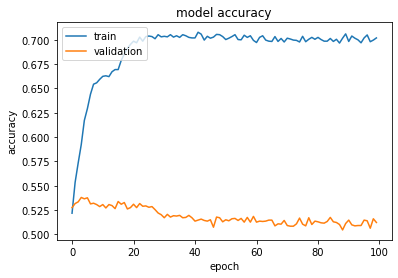

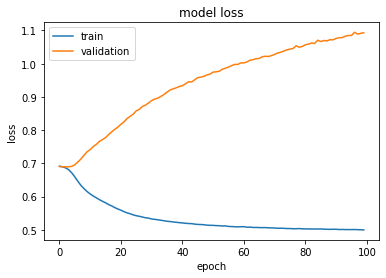

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: `[batch_size, 2 * embedding_dim + 1]`

*     **Sum**: `[batch_size, embedding_dim + 1]`

*     **Mean**: `[batch_size, embedding_dim + 1]`



# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

---

A. **Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

---

B. **Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set. 

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs. 

At this point, all we need to do is to compute the final predicted claim label via majority voting.

---

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

Shortly speaking, implement both strategies for your classification metrics.

In [68]:
#A Multi input classification evaluation
def inputClassificationEvaluation(y,predictions):
  return classification_report(np.array(y), np.array(predictions), 
                               target_names=['refutes','supports'],
                               labels=[0,1]);


#B Claim verification evaluation
def claim_verification_evaluation(X,y,predictions):
  y_final=[]
  predictions_final=[]
  ris_label = -1
  ris_predicted = -1

  X['Label'] = y
  X['Predicted'] = predictions
  claims =  X.Claim.unique()

  for el in claims:
    #get every row with same Claim
    rows = X.loc[X['Claim'] == el]
    #get an array of the real label
    label = np.array(rows.Label)
    #get an array with the predictions
    predicted = np.array(rows.Predicted)
    #check the higher number of vote
    if sum(label) >= label.size/2:
      ris_label = 1
    else:
      ris_label = 0
    if sum(predicted) >=  predicted.size/2:
      ris_predicted = 1
    else:
      ris_predicted = 0
    #append to the final result 
    y_final.append(ris_label)
    predictions_final.append(ris_predicted)
  return inputClassificationEvaluation(y_final,predictions_final)






# Tips and Extras

## 8.1 Extensions are welcome!

Is this task too easy for you? Are you curious to try out things you have seen during lectures (e.g. attention)? Feel free to try everything you want!

**Don't forget to try neural baselines first!**

## 8.2 Comments and documentation

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

## 8.3 Organization

We suggest you to divide your work into sections. This allows you to build clean and modular code, as well as easy to read and to debug.

A possible schema:

*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation
*   Comments/Summary

# Evaluation

Which are the evaluation criteria on which we'll judge you and your work?

1. Pre-processing: whether you have done some pre-processing or not.
2. Sentence embedding: you should implement all required strategies (with an example and working code for each). That is, we, as evaluators, should be able to test all strategies without writing down new code.
3. Multiple inputs merging strategies: you should implement all required strategies (with an example and working code for each).
4. Similarity extension: you should implement the cosine similarity extension (with an example and working code).
5. Voting strategy: you should implement the majority voting strategy and provide results.
6. Report: when submitting your notebook, you should also attach a small summary report that describes what you have done (provide motivations as well for abitrary steps. For instance, "We've applied L2 regularization since the model was overfitting".

Extras (possible extra points):

1. Any well defined extension is welcome!
2. Well organized and commented code is as important as any other criteria.

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

*Note*: We highly recommend you to check the [course useful material](https://virtuale.unibo.it/pluginfile.php/1036039/mod_resource/content/2/NLP_Course_Useful_Material.pdf) for additional information before contacting us!

# FAQ

---

**Question**: Can I do something text pre-processing?

**Answer:** You have to! If you check text data, the majority of sentences need some cleaning.

---

**Question**: The model architecture schema is not so clear, are we doing end-to-end training?

**Answer**: Exactly! All models can be thought as:

1. Input
2. (word) Embedding
3. Sentence embedding
4. Multiple inputs merging
5. Classification

---

**Question**: Can I extend models by adding more layers?

**Answer**: Feel free to define model architectures as you wish, but remember satisfy our requirements. This assignment should not be thought as a competition to achieve the best performing model: fancy students that want to show off but miss required assignment objectives will be punished!!

---

**Question**: I'm struggling with the implementation. Can you help me?

**Answer**: Yes sure! Contact us and describe your issue. If you are looking for a particular type of operation, you can easily check the documentation of the deep learning framework you are using (google is your friend).

---

**Question**: Can I try other encoding strategies or neural architectures?

**Answer:** Absolutely! Remember to try out recommended neural baselines first and only then proceed with your extensions.

---

**Question**: Do we have to test all possible sentence embedding and input merging combinations?

**Answer**: Absolutely no! Feel free to pick one sentence embedding strategy and try all possible input merging strategies with it! For instance, pick the best performing sentence embedding method and proceed with next steps (extras included). Please, note that you still have to implement all mentioned strategies!

---

**Question**: I'm hitting out of memory error when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length
3. Check the efficiency of your custom code implementation (if any)
4. Try to define same length mini-batches to avoid padding (**It should not be necessary here!**)

---

**Question**: I'm hitting CUDNN_STATUS_BAD_PARAM error! What I'm doing wrong?

**Answer**: This error is a little bit tricky since the stack trace is not meaningful at all! This error occurs when the RNN is fed with a sequence of all 0s and pad masking is enabled (e.g. from the embedding layer). Please, check your conversion step, since there might be an error that leads to the encoding of a sentence to all 0s.

---